In [1]:
import pandas as pd
import quandl, math, datetime
import numpy as np 
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
style.use('ggplot')

In [2]:
df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]

In [3]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [4]:


df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]
print(df.head)

<bound method NDFrame.head of              Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                      
2004-08-19    50.322842  3.712563    0.324968   44659000.0
2004-08-20    54.322689  0.710922    7.227007   22834300.0
2004-08-23    54.869377  3.729433   -1.227880   18256100.0
2004-08-24    52.597363  6.417469   -5.726357   15247300.0
2004-08-25    53.164113  1.886792    1.183658    9188600.0
...                 ...       ...         ...          ...
2018-03-21  1094.000000  1.343693    0.130884    1990515.0
2018-03-22  1053.150000  2.921711   -2.487014    3418154.0
2018-03-23  1026.550000  3.918952   -2.360729    2413517.0
2018-03-26  1054.090000  0.491419    0.332191    3272409.0
2018-03-27  1006.940000  5.720301   -5.353887    2940957.0

[3424 rows x 4 columns]>


In [5]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace = True)

In [6]:
forecast_out = int(math.ceil(0.10 * len(df)))
print(forecast_out)

343


In [7]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [8]:
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace = True)
y = np.array(df['label'])

print(len(X), len(y))

3081 3081


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
# clf = LinearRegression(n_jobs = -1)
# clf.fit(X_train, y_train)

# with open('linearregression.pickle', 'wb') as f:
#     pickle.dump(clf, f)

pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)
accuracy = clf.score(X_test, y_test)
print(accuracy)
 
clf_svm = svm.SVR()
clf_svm.fit(X_train, y_train)
accuracy_svm = clf_svm.score(X_test, y_test)
print(accuracy_svm)

0.745781391226486
0.6996145339739737


In [11]:
forecast_set = clf.predict(X_lately)
# print(forecast_set, accuracy, forecast_out)

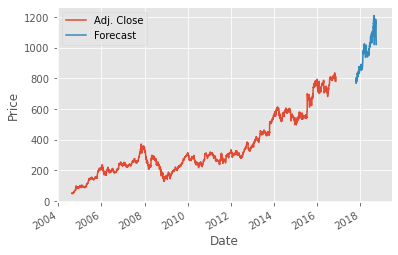

In [13]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)- 1)] + [i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
